# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [4]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.363703
sanity check: 2.302585


$$f(x, W) = - \log{(truescore(\frac{e^{X.dot(W)}}{sum (e^{(X.dot(W))})})}) $$

In [4]:
X_dev.shape, W.shape

((500, 3073), (3073, 10))

In [6]:
np.zeros(scores.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
reg = 5e1
dW= np.zeros(W.shape)
scores = np.zeros((X_dev.shape[0], W.shape[1]))
dprobs = np.zeros(scores.shape)
for i in range(0, X_dev.shape[0]):
    for j in range(0, W.shape[1]):
        dot = np.sum(X_dev[i, :]*(W[:, j])) #1 (1)
        scores[i, j] = dot  #(1)
    scores[i, :] -= np.max(scores[i, :]) #avoiding numerical stabilization
    scores_exp = np.exp(scores[i, :]) #2 (1,10)
    num = scores_exp #3 #numerator (1,10)
    den = scores_exp.sum() #3 (1)
    invden = 1 / den #3.5 #denumerator > (1) 
    probs = num * invden #4 #sigmoid is done (1, 10) #broadcast
    tclass_prob = probs[y_dev[i]] #5 (1)
    tclass_lprob = np.log(tclass_prob) #6 (1)
    loss += -(tclass_lprob) #7 (1)
    
    #derivative with chain rule
    dloss = 1
    dtclass_lprob = -1*dloss #7 # shape > 1
    dtclass_prob = (1/tclass_prob)*dtclass_lprob #6  # shape > 1
    
    dprobs[i, y_dev[i]] = 1*dtclass_prob
    dnum = invden*dprobs[i, :] #(1, 10)
    dinvden = num*dprobs[i, :] #(1, 10)
    
    dden = (-1 / den**2)*dinvden #(1,10) #broadcast

    dscores_exp = 1*dnum #(1)
    dscores_exp += W.shape[1]*dden #(1,10)broadcast
    
    ddot = scores[i, :]*dscores_exp #(1,10)
    dW += X_dev[i, :].reshape(-1,1).dot(ddot.reshape(1,-1)) # dscores > (1,10) dW > 3073x10
    
#     dscores_exp = inv_scores_sum*dnormalized_scores #4 # 1 number
#     dinv_scores_sum = scores_exp*dnormalized_scores #4 # (1,10), true class score affect all of the classes?
    
#     dscores_sum = (-1/scores_sum**2)*dinv_scores_sum #4
#     dscores_exp += dscores_sum.sum() #3
#     dscores_i = np.exp(scores[i, :])*dscores_exp #2
#     ddot = scores[i, :] * dscores_i #1
#     dW += X_dev[i, :].reshape(W.shape[0],-1) * ddot.reshape(1, -1) 
#     #ddot*X_dev[i, :]
    
#     #ddot = ((1 - scores[i, y_dev[i]])*scores[i, y_dev[i]])*d_loss
#     #dW[:, y_dev[i]] += X_dev[i, :] * ddot
loss = loss / X_dev.shape[0]
loss += reg*np.sum(W*W)
dW = dW / X_dev.shape[0]
dW += reg*2*W
print(loss)
print(dW)
# This is wrong

2.3684291256287118
[[-3.30258445e+00  1.91067564e-01  3.23146204e-01 ... -1.07432520e+00
  -6.97318758e-01  2.80702307e+01]
 [-2.97919271e+00 -2.03882471e-01  2.14099224e-01 ... -1.01489643e+00
  -6.24077901e-01  2.70221629e+01]
 [-2.67890046e+00  1.75384258e-01 -1.40236123e-01 ... -1.05270564e+00
  -4.35224148e-01  2.84273612e+01]
 ...
 [-2.14623821e+00 -4.46821912e+00  3.83517115e-01 ... -1.13158080e-01
  -8.41667247e-01  1.33834471e+01]
 [-1.71455512e+00 -3.99250254e+00  3.77918718e-01 ... -4.39905364e-01
  -7.94512223e-01  1.48705781e+01]
 [ 2.98973124e-02  7.13917671e-02  1.27874409e-02 ...  2.04510829e-02
   3.66829281e-02  3.16310682e-01]]


In [7]:
X_dev.shape, (X_dev.shape[0], W.shape[1]), W.shape

((500, 3073), (500, 10), (3073, 10))

In [11]:
X_dev[0, :].reshape(1,-1).shape

(1, 3073)

In [19]:
W[2].shape

(10,)

In [23]:
(X_dev[2]*softmax[3]).shape

(3073,)

In [21]:
X_dev[1].shape

(3073,)

In [25]:
reg = 5e1
loss = 0
dW= np.zeros(W.shape)
scores = np.zeros((X_dev.shape[0], W.shape[1]))
for i in range(0, X_dev.shape[0]):
    scores[i, :] = X_dev[i, :].dot(W) #1
    scores[i, :] -= np.max(scores[i, :]) # for numerical stabilization
    scores_exp = np.exp(scores[i, :])
    sum_scores_exp = np.sum(scores_exp)
    softmax = scores_exp / sum_scores_exp #2 This is softmax function
    loss += -np.log(softmax[y_dev[i]]) # this is loss
    for j in range(0, W.shape[1]):
        dW[:, j] += X_dev[i]*(softmax[j] - (j == y_dev[i])) 
loss = loss / X_dev.shape[0]
loss += reg*np.sum(W*W)
dW = dW / X_dev.shape[0]
dW += reg*2*W
print(loss)
#print(loss)
print(dW)
# This true one

2.379192849691707
[[-5.47368395e-01 -1.27419918e+00  1.88205005e+00 ... -1.50083110e+00
  -4.25679303e+00 -3.46879517e+00]
 [-1.69290080e+00 -1.16872206e+00  2.12055381e+00 ... -8.01905418e-01
  -5.60188356e+00 -3.31415553e+00]
 [-3.58606160e+00 -8.96670146e-01  3.84501024e+00 ... -6.89355518e-01
  -7.47693544e+00 -3.91738414e+00]
 ...
 [-1.63739490e+00 -9.28107036e-01  2.40136182e-01 ... -1.06588004e+00
   8.00295806e-02 -1.63917251e-01]
 [-3.18341887e+00 -1.35665173e+00  7.45440626e-01 ...  7.00593840e-01
  -1.90780909e+00 -5.92967939e-01]
 [-1.46709188e-02  9.98736828e-04 -7.56257664e-03 ... -1.52372427e-02
   1.61433792e-02 -1.60441344e-03]]


In [12]:
X_dev[1, :].shape

(3073,)

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Initially all weights are close to 0, so scores. If we exponentiate the scores, we get 1 for each class and example. Then we normalize them, they are going to be 1/number of classes. And loss is -log(1/number of classes) which in this case is -log(0.1)*


In [26]:
np.random.seed(18)

In [27]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.873171 analytic: 1.873170, relative error: 2.016002e-08
numerical: 1.907278 analytic: 1.907277, relative error: 3.197197e-08
numerical: 2.217485 analytic: 2.217485, relative error: 2.637882e-08
numerical: 1.433238 analytic: 1.433237, relative error: 3.265327e-08
numerical: 0.425800 analytic: 0.425800, relative error: 3.028803e-08
numerical: 1.389049 analytic: 1.389049, relative error: 6.411725e-09
numerical: -5.564195 analytic: -5.564195, relative error: 3.985556e-09
numerical: -0.353025 analytic: -0.353025, relative error: 3.979869e-08
numerical: 0.882581 analytic: 0.882581, relative error: 4.994542e-08
numerical: 0.882032 analytic: 0.882032, relative error: 3.495774e-08
numerical: 2.094539 analytic: 2.094539, relative error: 1.544953e-08
numerical: -0.789689 analytic: -0.789689, relative error: 7.070002e-09
numerical: 0.206024 analytic: 0.206024, relative error: 2.971616e-07
numerical: -2.930770 analytic: -2.930770, relative error: 7.358611e-10
numerical: -4.725928 analy

In [59]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.363703e+00 computed in 0.109727s
vectorized loss: 2.363703e+00 computed in 0.003198s
Loss difference: 0.000000
Gradient difference: 0.000000


In [57]:
#vectorized loss
loss = 0.0
dW = np.zeros_like(W)
reg = 0.000005
#############################################################################
# TODO: Compute the softmax loss and its gradient using no explicit loops.  #
# Store the loss in loss and the gradient in dW. If you are not careful     #
# here, it is easy to run into numeric instability. Don't forget the        #
# regularization!                                                           #
#############################################################################
N = X_dev.shape[0]
scores = X_dev.dot(W)
scores -= np.max(scores, axis = 1).reshape(N, 1) #for numerical stability
exp = np.exp(scores)
softmax = exp / exp.sum(axis=1).reshape(N, 1)
true_class_probs = softmax[range(0, N), y_dev]
losses = -np.log(true_class_probs)

#total loss
loss = np.sum(losses) / N  
# add regularization
loss += reg*np.sum(W*W)
print(loss)

#vectorized dW
gama = np.zeros(softmax.shape)
gama[range(0, N), y_dev] = 1
dW = X_dev.T.dot(softmax - gama)
dW = dW / X_dev.shape[0]
dW += 2*reg*W 
print(dW)

2.363702846528864
[[-5.38151747e-01 -1.27593777e+00  1.87474659e+00 ... -1.51522495e+00
  -4.25594024e+00 -3.47406459e+00]
 [-1.70647053e+00 -1.16971899e+00  2.10652113e+00 ... -8.11868603e-01
  -5.60595574e+00 -3.30486339e+00]
 [-3.58856488e+00 -8.73149754e-01  3.85559678e+00 ... -7.14540641e-01
  -7.47511105e+00 -3.90727226e+00]
 ...
 [-1.64411915e+00 -9.38814980e-01  2.48377634e-01 ... -1.06907708e+00
   8.49706781e-02 -1.70899359e-01]
 [-3.17541041e+00 -1.37473675e+00  7.33698032e-01 ...  7.16189511e-01
  -1.89618022e+00 -5.86477590e-01]
 [-9.95622101e-03  1.56193886e-02 -1.02624664e-02 ... -9.43419932e-03
   1.39286034e-02  5.86233989e-03]]


In [39]:
X_dev.T.dot(softmax).shape

(3073, 10)

In [35]:
W.shape, X_dev.shape, softmax.shape

((3073, 10), (500, 3073), (500, 10))

In [60]:
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 771.796035
iteration 100 / 1500: loss 283.418456
iteration 200 / 1500: loss 105.122459
iteration 300 / 1500: loss 39.695857
iteration 400 / 1500: loss 15.892416
iteration 500 / 1500: loss 7.117263
iteration 600 / 1500: loss 3.937407
iteration 700 / 1500: loss 2.746157
iteration 800 / 1500: loss 2.387738
iteration 900 / 1500: loss 2.204839
iteration 1000 / 1500: loss 2.082849
iteration 1100 / 1500: loss 2.075393
iteration 1200 / 1500: loss 2.103925
iteration 1300 / 1500: loss 2.036888
iteration 1400 / 1500: loss 2.048126
That took 5.888890s


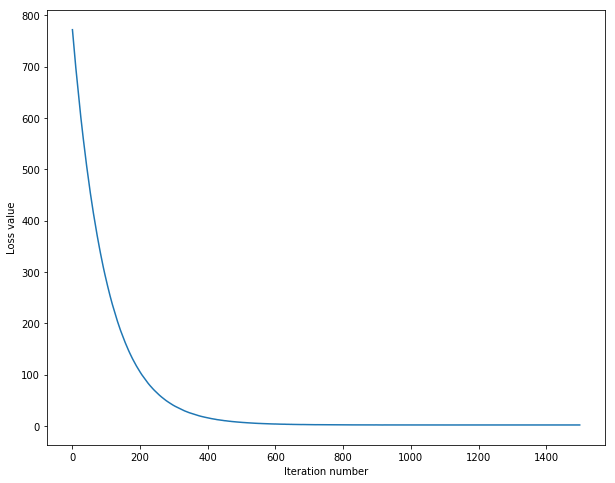

In [61]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [62]:
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.325061
validation accuracy: 0.340000


In [63]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1200, verbose=True) 
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        valid_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, valid_accuracy)
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1200: loss 762.152331
iteration 100 / 1200: loss 280.377946
iteration 200 / 1200: loss 103.829261
iteration 300 / 1200: loss 39.428540
iteration 400 / 1200: loss 15.737355
iteration 500 / 1200: loss 7.064716
iteration 600 / 1200: loss 3.970058
iteration 700 / 1200: loss 2.819893
iteration 800 / 1200: loss 2.330362
iteration 900 / 1200: loss 2.193980
iteration 1000 / 1200: loss 2.155190
iteration 1100 / 1200: loss 2.128278
iteration 0 / 1200: loss 1519.855688
iteration 100 / 1200: loss 204.566020
iteration 200 / 1200: loss 29.178116
iteration 300 / 1200: loss 5.734122
iteration 400 / 1200: loss 2.617597
iteration 500 / 1200: loss 2.234343
iteration 600 / 1200: loss 2.158253
iteration 700 / 1200: loss 2.134295
iteration 800 / 1200: loss 2.146020
iteration 900 / 1200: loss 2.089884
iteration 1000 / 1200: loss 2.170265
iteration 1100 / 1200: loss 2.129980
iteration 0 / 1200: loss 766.563784
iteration 100 / 1200: loss 6.847182
iteration 200 / 1200: loss 2.079280
iteration 300 

In [64]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.343000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

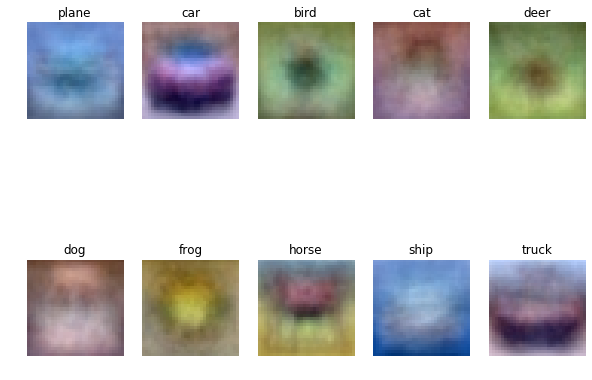

In [65]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])